## 0. Notebook description

This notebook represents our baseline. It uses five convolutional layers and achieves an accuracy of 0.83. In the following notebooks we try to improve this accuracy even further by changing the CNN model or increasing the number of input images (augmentation, GAN).

## 1. Importing libraries and loading the data

In [13]:
# Import Libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
from collections import Counter
from sklearn.metrics import classification_report
from utils.preprocessing import oversample_data, split_data, load_data, ReshapeAndScale, create_dataloaders
from utils.fer2013_dataset import Fer2013Dataset

First, we load the data into a pandas dataframe.

In [14]:
data_unprocessed= load_data("data/train.csv")
print(data_unprocessed.head(10))

   emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
5        2  55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...
6        4  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
7        3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
8        3  85 84 90 121 101 102 133 153 153 169 177 189 1...
9        2  255 254 255 254 254 179 122 107 95 124 149 150...


In [15]:
# Checking Shape of data
data_unprocessed.shape

(28709, 2)

## 2. Preprocessing data

The cell below shows that there are no missing values. It is therefore not necessary to impute anything.

In [16]:
data_unprocessed.isnull().values.any()

False

### Split the dataset into train and validation data

We use our full dataset object and split it into training and validation sets (80% and 20%). We also visualize the training and validation sets to see the class distribution.


In [17]:
def visualize_label_distribution(df, emotion_labels, title, verbose=True, colors=None):
    """
    Visualizes the label distribution in a pandas DataFrame dataset.

    Parameters
    ----------
    df : pd.DataFrame
        The dataset to analyze, should contain an 'emotion' column.
    emotion_labels : dict
        A dictionary mapping label indices to emotion names.
    title : str
        The title for the visualization.
    verbose : bool, optional
        Whether to print dataset size and class distribution. Default is True.
    colors : list, optional
        List of colors for the bar chart. Default is None.

    Returns
    -------
    None
    """
    import matplotlib.pyplot as plt

    # Extract all labels from the 'emotion' column of the DataFrame
    all_labels = df['emotion'].values

    # Count occurrences of each label
    class_counts = Counter(all_labels)

    # Sort labels by class index
    sorted_keys = sorted(class_counts.keys())
    sorted_counts = [class_counts[key] for key in sorted_keys]
    sorted_labels = [emotion_labels.get(key, f"Class {key}") for key in sorted_keys]

    # Verbose Output
    if verbose:
        print(f"{title} Dataset Size: {len(df)}")
        print(f"{title} Class Distribution: {class_counts}")

    # Visualization
    plt.bar(sorted_keys, sorted_counts, tick_label=sorted_labels, color=colors)
    plt.xlabel("Emotion Classes")
    plt.ylabel("Frequency")
    plt.title(f"{title} Label Distribution (Total: {len(df)})")
    plt.show()


Training Dataset Size: 22967
Training Class Distribution: Counter({3: 5772, 6: 3972, 4: 3864, 2: 3277, 0: 3196, 5: 2537, 1: 349})


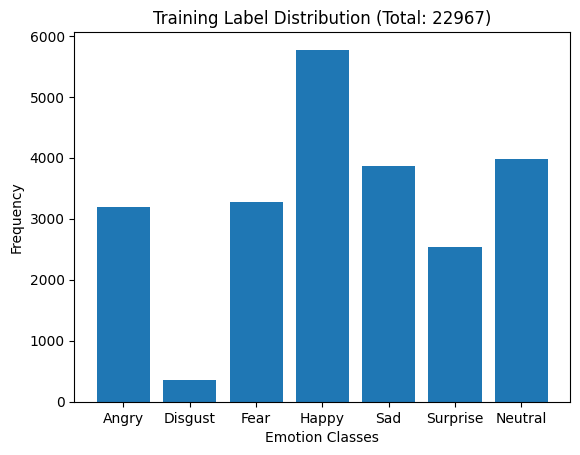

Validation Dataset Size: 5742
Validation Class Distribution: Counter({3: 1443, 6: 993, 4: 966, 2: 820, 0: 799, 5: 634, 1: 87})


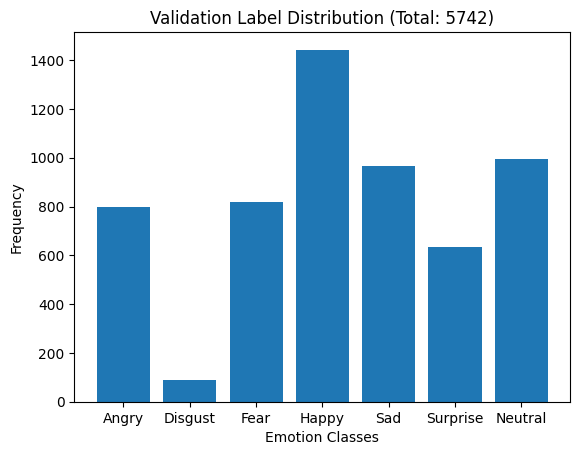

In [18]:
train_df, val_df = split_data(data_unprocessed, train_split=0.8)

emotion_labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

visualize_label_distribution(train_df, emotion_labels, "Training")
visualize_label_distribution(val_df, emotion_labels, "Validation")

### Oversampling

As we have seen in the plots, the data is highly inbalanced. Therefore, we first over-sample the minority classes in the training set using RandomOverSampler so that the emotion classes are evenly distributed

In [19]:
oversampled_train_data = oversample_data(train_df['pixels'], train_df['emotion'])
oversampled_train_data = oversampled_train_data.reset_index(drop=True)

# Print the new shape and label distribution
print(oversampled_train_data.shape)
print(oversampled_train_data['emotion'].value_counts())


(40404, 2)
emotion
4    5772
1    5772
6    5772
2    5772
3    5772
5    5772
0    5772
Name: count, dtype: int64


## 3. Define a custom dataset

We define a custom PyTorch dataset class, `Fer2013Dataset`, for handling the FER2013 data. The dataset is designed to load images (stored as pixel strings) and their corresponding emotion labels. It also supports optional transformations to preprocess the images during training. This setup makes it easy to integrate the dataset with PyTorch DataLoaders.

The class is contained in the `utils/fer2013_dataset` file

We also apply the following preprocessing steps to convert the data into the desired format we can further work with:
1. **Reshaping**:
   - Convert the pixel string into a `48x48` matrix for visualization and processing.
2. **Scaling**:
   - Scale pixel values to the range `[0, 1]` by dividing the pixel values by 255.
3. **Normalization**:
   - Normalize pixel values to the range `[-1, 1]` by subtracting the mean and diving them by the standard deviation.


These preprocessing steps are contained in the class `ReshapeAndScale`, which is available under path `utils/preprocessing.py`.

In [20]:
# Define a default transformation pipeline
transform = transforms.Compose([
    ReshapeAndScale(n_rows=48, n_cols=48),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

In [21]:
train_dataset = Fer2013Dataset(train_df, train_df['emotion'], transform=transform)
val_dataset = Fer2013Dataset(val_df, val_df['emotion'], transform=transform)

### Create DataLoaders

We create DataLoaders for both subsets to enable batch processing. The training DataLoader shuffles the data for better learning, while the validation DataLoader does not. Finally, we print the shapes of the batches to verify that everything works correctly.


In [22]:
batch_size = 32
train_loader, val_loader = create_dataloaders(oversampled_train_data, val_dataset, batch_size)

## 4. Define the CNN model

We define a custom Convolutional Neural Network (CNN) for emotion recognition. The model includes multiple convolutional layers with batch normalization, dropout for regularization, max pooling for downsampling, and fully connected layers for classification. 

The network dynamically calculates the flattened size needed for the fully connected layers based on the input size (48x48 grayscale images). Finally, we instantiate the model, move it to the available device (CPU or GPU), and print its architecture for verification.


In [23]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # 1st Conv Layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding='valid')
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.25)

        # 2nd Conv Layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3rd Conv Layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='valid')
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout(0.25)

        # 4th Conv Layer
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 5th Conv Layer
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='valid')
        self.bn5 = nn.BatchNorm2d(128)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the flatten size dynamically
        self.flatten_size = self._get_flatten_size()

        # Fully Connected Layers
        self.fc1 = nn.Linear(self.flatten_size, 250)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(250, 7)  # 7 classes for emotion recognition

    def _get_flatten_size(self):
        # Create a dummy tensor with the same size as input image
        dummy_input = torch.zeros(1, 1, 48, 48)  # batch_size, channels, height, width
        dummy_output = self._forward_conv_layers(dummy_input)
        return dummy_output.numel()

    def _forward_conv_layers(self, x):
        # Pass through convolutional layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool4(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.pool5(x)

        return x

    def forward(self, x):
        # Use the convolutional layers defined in _forward_conv_layers
        x = self._forward_conv_layers(x)

        # Dynamically flatten the output
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)

        return x

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN()
model = model.to(device)

# Print model to verify layers
print(model)    

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=val

## 5. Define Loss Function and Optimizer

In this cell, we define the loss function and optimizer for training the model:
- **Loss Function**: `CrossEntropyLoss` is used, which is well-suited for multi-class classification tasks like emotion recognition.
- **Optimizer**: The Adam optimizer is initialized with a learning rate of `0.0001` to update the model parameters during training.

In [24]:
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # call optimizer

## 6. Train the Model

In this cell, we define the training loop for the CNN:
- **Number of Epochs**: The model is trained for 35 epochs.
- **Training Process**:
  - The model is set to training mode.
  - For each batch, we move inputs and labels to the appropriate device, clear the gradients, perform forward and backward passes, and update the model's parameters using the optimizer.
  - The running loss is tracked and printed every 100 batches for monitoring.

In [25]:
# Initialize TensorBoard writer
writer = SummaryWriter(log_dir='facial-expression-detection/1_Group17_DLProject')

checkpoint_path = 'model-checkpoints/1_Group17_DLProject'
os.makedirs(checkpoint_path, exist_ok=True)

num_epochs = 35
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 100 == 0:  # Print every 100 batches
            avg_loss = running_loss / 100
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {avg_loss:.4f}")
            running_loss = 0.0

            # Log loss to TensorBoard
            writer.add_scalar('Loss/train', avg_loss, epoch)

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss,
        }
        torch.save(checkpoint, f"{checkpoint_path}/checkpoint_epoch_{epoch + 1}.pth")
        print(f"Checkpoint saved at epoch {epoch + 1}")

# Close the writer after training
writer.close()

KeyError: 24715

## 7. Evaluate the Model

In this cell, we evaluate the trained model using the validation dataset:
- The model is set to evaluation mode, and gradient computation is disabled.
- For each batch, we perform a forward pass and predict the class labels.
- Ground truth labels and predictions are stored and used to generate a classification report using `sklearn`. This report provides precision, recall, and F1-scores for each emotion class.

In [12]:
# Switch model to evaluation mode
model.eval()

# Initialize lists to store ground truth and predictions
y_true, y_pred = [], []

# Disable gradient computation
with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get the predicted class
        _, predicted = torch.max(outputs, 1)

        # Append ground truth and predictions to respective lists
        y_true.extend(labels.cpu().numpy())  # Convert tensors to numpy
        y_pred.extend(predicted.cpu().numpy())

# Generate the classification report
emotion_labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
print(classification_report(y_true, y_pred, target_names=list(emotion_labels.values())))


              precision    recall  f1-score   support

       Angry       0.81      0.81      0.81      1429
     Disgust       0.99      1.00      0.99      1464
        Fear       0.72      0.82      0.77      1441
       Happy       0.88      0.76      0.82      1420
         Sad       0.74      0.72      0.73      1492
    Surprise       0.92      0.94      0.93      1450
     Neutral       0.75      0.74      0.75      1405

    accuracy                           0.83     10101
   macro avg       0.83      0.83      0.83     10101
weighted avg       0.83      0.83      0.83     10101



### Conclusion
As we have a balanced dataset, we measure performance based on accuracy. The report above shows that our baseline already achieves a good accuracy of 0.83, which we will try to improve in the next notebooks.